IMPORT LIBRARIES

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

LOAD DATA

In [2]:
df = pd.read_excel("Social_Network_Ads.xlsx")
df["label"] = df.Purchased
df = df.drop("Purchased", axis=1)

column_names = []
for column in df.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
df.columns = column_names

df.head()

,User_ID_,Gender_,Age_,EstimatedSalary_,label
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


CHECK WHETHER THE DATASET HAS NULL VALUES

In [3]:
df.isnull().sum()

User_ID_            0
Gender_             0
Age_                0
EstimatedSalary_    0
label               0
dtype: int64

CHANGE CATEGORICAL DATA TO NUMERIC

In [4]:
df = pd.get_dummies(df)
df.head()

,User_ID_,Age_,EstimatedSalary_,label,Gender__Female,Gender__Male
0,15624510,19,19000,0,0,1
1,15810944,35,20000,0,0,1
2,15668575,26,43000,0,1,0
3,15603246,27,57000,0,1,0
4,15804002,19,76000,0,0,1


CHECK FOR CORRELATION

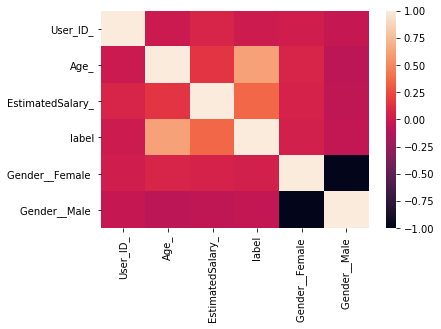

In [5]:
corr=df.corr()
sns.heatmap(corr)

DROP THE COLUMNS

In [6]:
df.drop('User_ID_',axis='columns', inplace=True)
df.drop('Gender__Female ',axis='columns',inplace=True)
df.drop('Gender__Male ',axis='columns', inplace=True)

TRAIN TEST SPLIT

In [7]:
x = df.iloc[:,:-1].values
y = df.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [9]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


ACCURACY

In [10]:
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy

PURITY CHECK

In [11]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False


CLASSIFY

In [12]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification


POTENTIAL SPLITS

In [13]:
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


LOWEST OVERALL ENTROPY

In [14]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


In [15]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy


In [16]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


SPLIT DATA

In [17]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


DECISION TREE ALGORITHM

In [18]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


MAKE PREDICTIONS

In [19]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [20]:
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

RANDOM FOREST ALGORITHM

In [21]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.2)

In [22]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped


In [23]:
def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest


In [24]:
def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

ACCURACY FOR THE RANDOM FOREST MODEL

In [25]:
forest = random_forest_algorithm(train_df, n_trees=4, n_bootstrap=800, n_features=2, dt_max_depth=4)
predictions = random_forest_predictions(test_df, forest)
accuracy = calculate_accuracy(predictions, test_df.label)

print("Accuracy = {}".format(accuracy))

Accuracy = 0.925


In [26]:
pd.DataFrame({'Actual': predictions,'Predicted': (test_df.label)})

,Actual,Predicted
197,0.0,0
388,1.0,1
215,1.0,1
20,1.0,1
132,0.0,0
...,...,...
63,1.0,1
276,0.0,0
300,1.0,1
147,0.0,0


CONFUSION MATRIX

In [27]:
from sklearn.ensemble import RandomForestClassifier
random_forest_alogorith = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
random_forest_alogorith.fit(X_train, y_train)
y_pred = random_forest_alogorith.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[63,  5],
       [ 4, 28]], dtype=int64)

OUTPUT PLOT

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


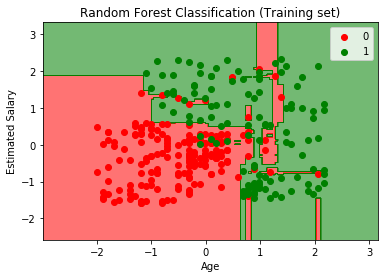

In [28]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, random_forest_alogorith.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.55, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()